<a href="https://colab.research.google.com/github/Apurva3509/Applied-Machine-Learning/blob/main/Colab_Files/COMS4995_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMS 4995 Applied ML Project: NYPD Complaints**


## Mounting drive

In [1]:
import os

In [2]:
cd /content/drive/MyDrive/AML_DS

/content/drive/MyDrive/AML_DS


In [3]:
ls

NYPD_Complaint_Data_Current__Year_To_Date__20240323.csv
NYPD_Complaint_Incident_Level_Data_Footnotes.pdf
NYPD_Incident_Level_Data_Column_Descriptions.csv


## Installing dependencies

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from mpl_toolkits.mplot3d import Axes3D

In [7]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve

# Predefining Functions

In [8]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = math.ceil((nCol + nGraphPerRow - 1) / nGraphPerRow)  # Ensure nGraphRow is an integer
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [9]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

# Dataset Import

In [10]:
df=pd.read_csv('/content/drive/MyDrive/AML_DS/NYPD_Complaint_Data_Current__Year_To_Date__20240323.csv')
df.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New Georeferenced Column
0,269235387,42.0,BRONX,06/03/2023,01:00:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,25-44,BLACK HISPANIC,M,1011982.0,239520.0,40.824059,-73.899799,"(40.82405906, -73.89979939)",POINT (-73.89979939 40.82405906)
1,262102261,43.0,BRONX,01/18/2023,14:00:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,UNKNOWN,UNKNOWN,E,1019635.0,243829.0,40.835859,-73.872125,"(40.83585867, -73.87212505)",POINT (-73.87212505 40.83585867)
2,267972239,43.0,BRONX,05/07/2023,00:15:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,25-44,BLACK,F,1022051.0,242244.0,40.831500,-73.863400,"(40.8315, -73.8634)",POINT (-73.8634 40.8315)
3,263141402H1,NaN,BROOKLYN,02/06/2023,10:16:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,18-24,BLACK,M,NaN,NaN,NaN,NaN,NaN,NaN
4,269307857H1,NaN,BROOKLYN,06/04/2023,00:20:00,NaN,(null),COMPLETED,(null),NaN,...,NaN,25-44,BLACK,M,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis

In [11]:
data = df.drop(columns=['New Georeferenced Column'])

In [12]:
print("No. of data points: ", data.shape[0])
print("No. of Features: ", data.shape[1])

No. of data points:  555117
No. of Features:  35


In [13]:
columns = data.columns
columns

Index(['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
       'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT',
       'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD',
       'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD',
       'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude',
       'Longitude', 'Lat_Lon'],
      dtype='object')

In [14]:
data.nunique()

CMPLNT_NUM           555117
ADDR_PCT_CD              77
BORO_NM                   6
CMPLNT_FR_DT           2148
CMPLNT_FR_TM           1440
CMPLNT_TO_DT           1523
CMPLNT_TO_TM           1441
CRM_ATPT_CPTD_CD          2
HADEVELOPT               26
HOUSING_PSA             375
JURISDICTION_CODE        22
JURIS_DESC               22
KY_CD                    68
LAW_CAT_CD                3
LOC_OF_OCCUR_DESC         6
OFNS_DESC                64
PARKS_NM                509
PATROL_BORO               8
PD_CD                   374
PD_DESC                 365
PREM_TYP_DESC            84
RPT_DT                  365
STATION_NAME            369
SUSP_AGE_GROUP           30
SUSP_RACE                 8
SUSP_SEX                  4
TRANSIT_DISTRICT         12
VIC_AGE_GROUP            35
VIC_RACE                  8
VIC_SEX                   5
X_COORD_CD            50135
Y_COORD_CD            52948
Latitude              78551
Longitude             79065
Lat_Lon               82624
dtype: int64

In [15]:
# cols = ['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
#        'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT',
#        'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD',
#        'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD',
#        'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP',
#        'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP',
#        'VIC_RACE', 'VIC_SEX']

# for column_name in cols:
#     counts = data[column_name].value_counts()
#     print(f"Unique values and their frequencies for column '{column_name}':")
#     print(counts)
#     print()

In [16]:
missing_values = data.isnull().sum().sort_values(ascending=False)

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
TRANSIT_DISTRICT     540384
HOUSING_PSA          519092
CMPLNT_TO_DT          34738
PD_CD                   386
ADDR_PCT_CD              70
Y_COORD_CD               12
Latitude                 12
X_COORD_CD               12
Longitude                12
Lat_Lon                  12
VIC_SEX                   0
VIC_RACE                  0
PREM_TYP_DESC             0
VIC_AGE_GROUP             0
SUSP_SEX                  0
SUSP_RACE                 0
SUSP_AGE_GROUP            0
STATION_NAME              0
RPT_DT                    0
CMPLNT_NUM                0
PD_DESC                   0
PARKS_NM                  0
OFNS_DESC                 0
LOC_OF_OCCUR_DESC         0
LAW_CAT_CD                0
KY_CD                     0
JURIS_DESC                0
JURISDICTION_CODE         0
HADEVELOPT                0
CRM_ATPT_CPTD_CD          0
CMPLNT_TO_TM              0
CMPLNT_FR_TM              0
CMPLNT_FR_DT              0
BORO_NM                   0
PATROL_BORO      

In [17]:
(data.isna().sum()/data.shape[0]*100).sort_values(ascending=False)

TRANSIT_DISTRICT     97.345965
HOUSING_PSA          93.510377
CMPLNT_TO_DT          6.257780
PD_CD                 0.069535
ADDR_PCT_CD           0.012610
Y_COORD_CD            0.002162
Latitude              0.002162
X_COORD_CD            0.002162
Longitude             0.002162
Lat_Lon               0.002162
VIC_SEX               0.000000
VIC_RACE              0.000000
PREM_TYP_DESC         0.000000
VIC_AGE_GROUP         0.000000
SUSP_SEX              0.000000
SUSP_RACE             0.000000
SUSP_AGE_GROUP        0.000000
STATION_NAME          0.000000
RPT_DT                0.000000
CMPLNT_NUM            0.000000
PD_DESC               0.000000
PARKS_NM              0.000000
OFNS_DESC             0.000000
LOC_OF_OCCUR_DESC     0.000000
LAW_CAT_CD            0.000000
KY_CD                 0.000000
JURIS_DESC            0.000000
JURISDICTION_CODE     0.000000
HADEVELOPT            0.000000
CRM_ATPT_CPTD_CD      0.000000
CMPLNT_TO_TM          0.000000
CMPLNT_FR_TM          0.000000
CMPLNT_F

# Data Processing & Cleaning

In [18]:
# drop rows with nan values for these important features
data.dropna(subset=['Y_COORD_CD','X_COORD_CD','Latitude','Longitude',
                  'CRM_ATPT_CPTD_CD','CMPLNT_FR_TM','Lat_Lon','CMPLNT_FR_DT',
                  'BORO_NM','OFNS_DESC'], inplace=True)

1. Dropping irrelevant features

In [19]:
data.columns

Index(['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
       'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT',
       'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD',
       'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD',
       'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude',
       'Longitude', 'Lat_Lon'],
      dtype='object')

In [20]:
# # Used this to get inof on each feature and decided which to drop

# feat = 'PATROL_BORO'
# print(data[feat].nunique(), '\n \n')
# print(data[feat].unique(), '\n \n')
# print(data[feat].value_counts(dropna=True))

In [21]:
data.drop(['STATION_NAME','TRANSIT_DISTRICT','HADEVELOPT','HOUSING_PSA'],axis='columns', inplace=True)

In [22]:
data['PARKS_NM'].nunique()

509

- Feature *`PARKS_NM`* has 509 unique values and serves no purpose currently because it doesn't have any spatial information associated with it whiuch can help segeregate data



In [23]:
data.drop(['PARKS_NM'] ,axis='columns', inplace=True)

- Feature `PD_CD` is an internal code for NYPD and is not useful to us so can be dropped

In [24]:
data.drop(['PD_CD'] ,axis='columns', inplace=True)

In [25]:
# data.drop(['ADDR_PCT_CD','PD_DESC'], axis='columns', inplace=True)

2. Processing important features for ML models

- In feature *`SUSP_AGE_GROUP`*, we consider values between 10 to 100 and keep `UNKNOWN` also whereas we remove *`null`* to make it more realistic and remove all the rest

In [26]:
data = data[data['SUSP_AGE_GROUP'] != '(null)']

In [27]:
valid_values = ['UNKNOWN', '18-24', '25-44', '45-64', '<18', '65+']
data = data[data['SUSP_AGE_GROUP'].isin(valid_values)]
print(data['SUSP_AGE_GROUP'].nunique(),'\n')
print(data['SUSP_AGE_GROUP'].value_counts(dropna=True))

6 

UNKNOWN    214407
25-44      156347
45-64       53650
18-24       40791
<18         11685
65+          6019
Name: SUSP_AGE_GROUP, dtype: int64


In [28]:
print('(', data.shape[0], ',', data.shape[1], ')')

( 482899 , 29 )


In [29]:
cols = ['SUSP_AGE_GROUP','VIC_AGE_GROUP']

for column_name in cols:
    counts = data[column_name].value_counts()
    print(f"Unique values and their frequencies for column '{column_name}':")
    print(counts)
    print()

Unique values and their frequencies for column 'SUSP_AGE_GROUP':
UNKNOWN    214407
25-44      156347
45-64       53650
18-24       40791
<18         11685
65+          6019
Name: SUSP_AGE_GROUP, dtype: int64

Unique values and their frequencies for column 'VIC_AGE_GROUP':
25-44      170340
UNKNOWN    141134
45-64       86981
18-24       40660
65+         23159
<18         20595
1023            5
-2              3
949             1
953             1
-962            1
-975            1
-953            1
-932            1
1020            1
-10             1
-46             1
1013            1
1018            1
-929            1
-971            1
962             1
-968            1
-58             1
-964            1
1022            1
-60             1
-6              1
-970            1
-30             1
Name: VIC_AGE_GROUP, dtype: int64



- In feature *`VIC_AGE_GROUP`* we keep the same categories as *`SUSP_AGE_GROUP`* and remove the rest to maintain uniformity and sticking to practical categories

In [30]:
data = data[data['VIC_AGE_GROUP'].isin(valid_values)]
print(data['VIC_AGE_GROUP'].nunique(),'\n')
print(data['VIC_AGE_GROUP'].value_counts(dropna=True))

6 

25-44      170340
UNKNOWN    141134
45-64       86981
18-24       40660
65+         23159
<18         20595
Name: VIC_AGE_GROUP, dtype: int64


- Feature *`VIC_SEX`* has a value *`L`*  which is not mentioned in the dataset description which is celarly a gebage value and is supposed to be eliminated.

In [31]:
data['VIC_SEX'].value_counts()

F    186435
M    162152
D     77824
E     52316
L      4142
Name: VIC_SEX, dtype: int64

In [32]:
data = data[data['VIC_SEX'] != 'L']
print(data['VIC_SEX'].value_counts())

F    186435
M    162152
D     77824
E     52316
Name: VIC_SEX, dtype: int64


- In feature *`BORO_NM`* we will omit where it's *(null)*.

In [33]:
data = data[data['BORO_NM'] != '(null)']
print(data['BORO_NM'].value_counts())

BROOKLYN         130035
MANHATTAN        119741
BRONX            105580
QUEENS           103063
STATEN ISLAND     20236
Name: BORO_NM, dtype: int64


- In feature *`LOC_OF_OCCUR_DESC`* we will fill `(null)` with *`UNKNOWN`*

In [53]:
data['LOC_OF_OCCUR_DESC'] = data['LOC_OF_OCCUR_DESC'].replace('(null)', np.nan)
data.fillna({'LOC_OF_OCCUR_DESC':'UNKNOWN'}, inplace=True)
print(data['LOC_OF_OCCUR_DESC'].value_counts())

INSIDE         259613
FRONT OF       112850
UNKNOWN         91546
OPPOSITE OF      7994
REAR OF          6495
OUTSIDE           157
Name: LOC_OF_OCCUR_DESC, dtype: int64


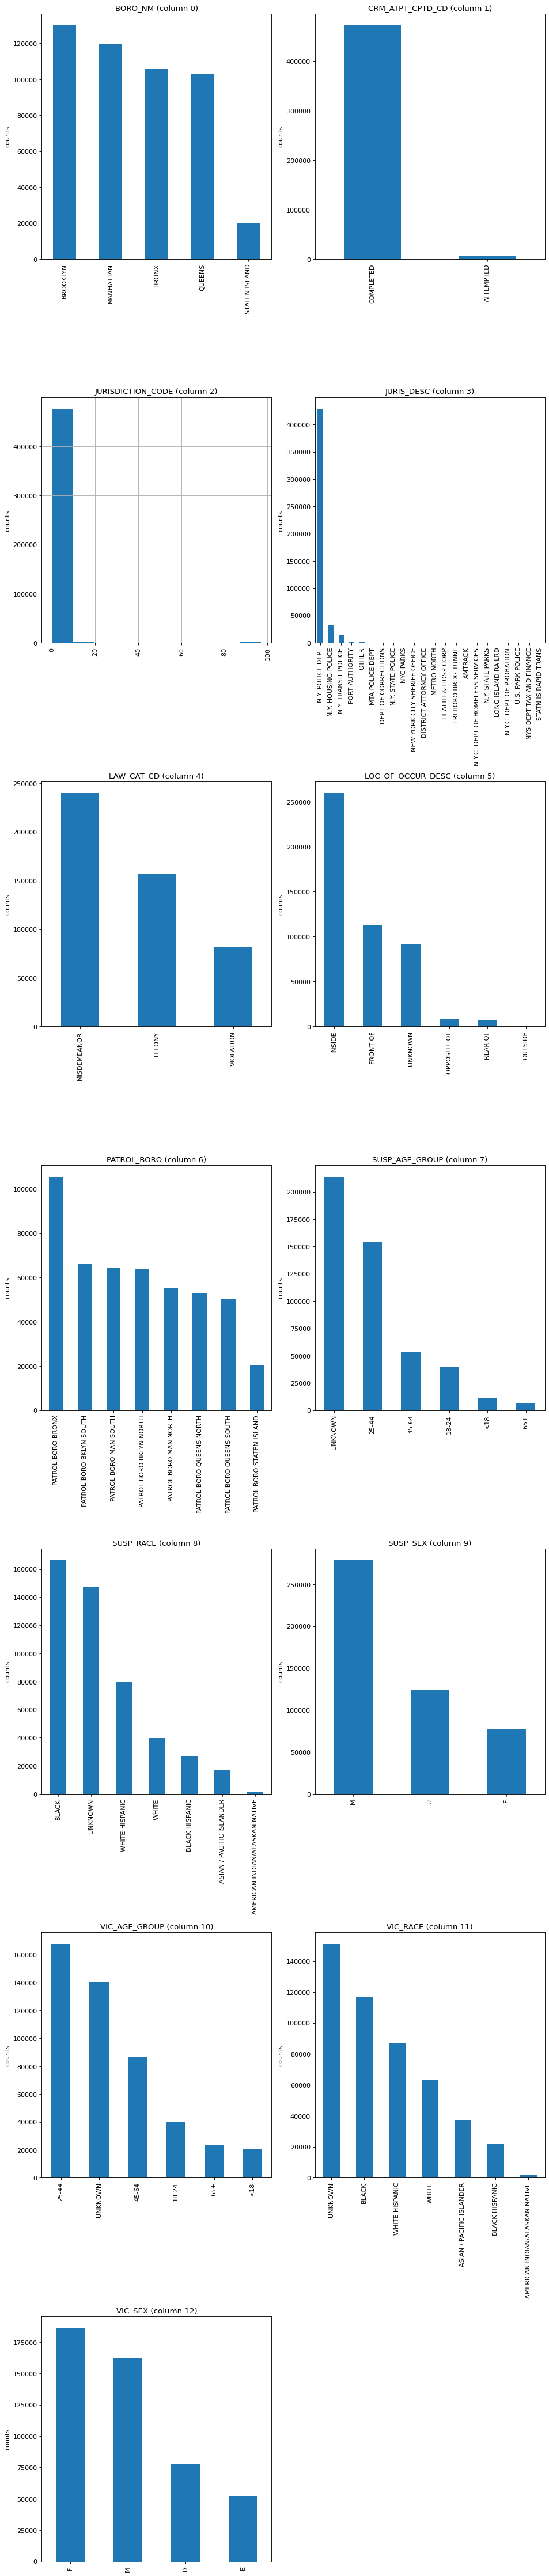

In [54]:
plotPerColumnDistribution(data, 50, 2)

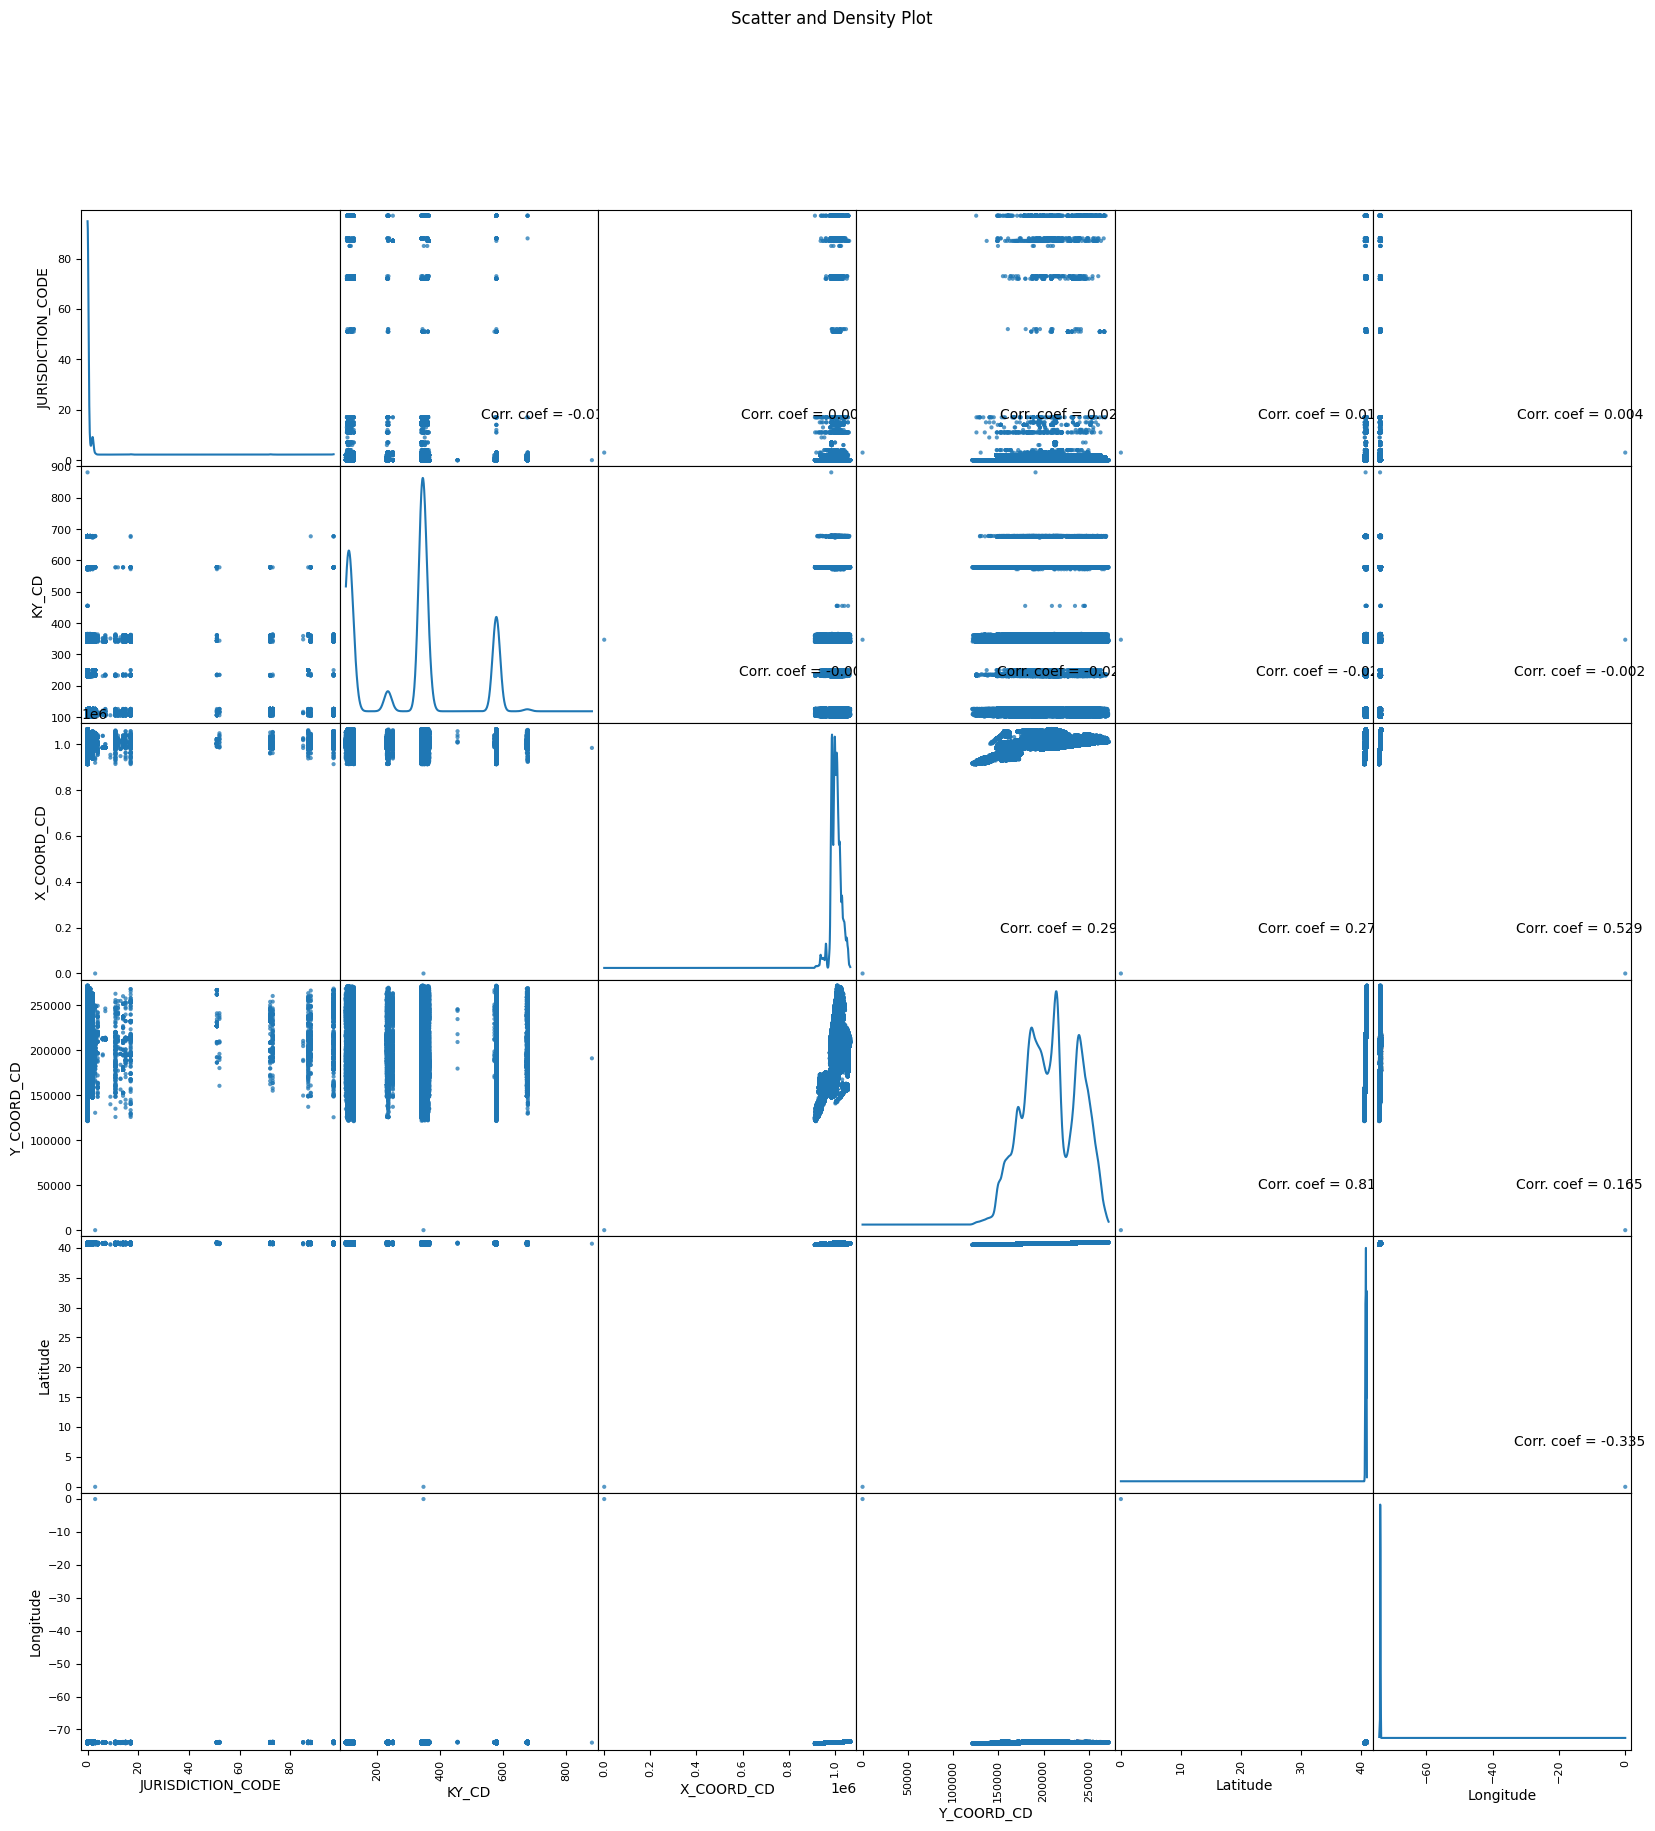

In [35]:
plotScatterMatrix(data, 20, 10)

In [36]:
data.nunique()

CMPLNT_NUM           478655
ADDR_PCT_CD              77
BORO_NM                   5
CMPLNT_FR_DT           1979
CMPLNT_FR_TM           1440
CMPLNT_TO_DT           1440
CMPLNT_TO_TM           1441
CRM_ATPT_CPTD_CD          2
JURISDICTION_CODE        22
JURIS_DESC               22
KY_CD                    68
LAW_CAT_CD                3
LOC_OF_OCCUR_DESC         6
OFNS_DESC                64
PATROL_BORO               8
PD_DESC                 357
PREM_TYP_DESC            84
RPT_DT                  365
SUSP_AGE_GROUP            6
SUSP_RACE                 7
SUSP_SEX                  3
VIC_AGE_GROUP             6
VIC_RACE                  7
VIC_SEX                   4
X_COORD_CD            47325
Y_COORD_CD            49909
Latitude              72078
Longitude             72510
Lat_Lon               75662
dtype: int64

In [37]:
print(data['Lat_Lon'].describe(),'\n\n')
print(data['Lat_Lon'].info())

count                     478655
unique                     75662
top       (40.750423, -73.98928)
freq                        1461
Name: Lat_Lon, dtype: object 


<class 'pandas.core.series.Series'>
Int64Index: 478655 entries, 0 to 555115
Series name: Lat_Lon
Non-Null Count   Dtype 
--------------   ----- 
478655 non-null  object
dtypes: object(1)
memory usage: 7.3+ MB
None


In [42]:
print(data['LOC_OF_OCCUR_DESC'].describe(),'\n\n')
print(data['LOC_OF_OCCUR_DESC'].info(),'\n\n')
print(data['LOC_OF_OCCUR_DESC'].unique())

count     478655
unique         6
top       INSIDE
freq      259613
Name: LOC_OF_OCCUR_DESC, dtype: object 


<class 'pandas.core.series.Series'>
Int64Index: 478655 entries, 0 to 555115
Series name: LOC_OF_OCCUR_DESC
Non-Null Count   Dtype 
--------------   ----- 
478655 non-null  object
dtypes: object(1)
memory usage: 7.3+ MB
None 


['(null)' 'FRONT OF' 'INSIDE' 'REAR OF' 'OPPOSITE OF' 'OUTSIDE']


In [41]:
data.columns

Index(['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
       'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'JURISDICTION_CODE',
       'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC',
       'PATROL_BORO', 'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX',
       'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lat_Lon'],
      dtype='object')

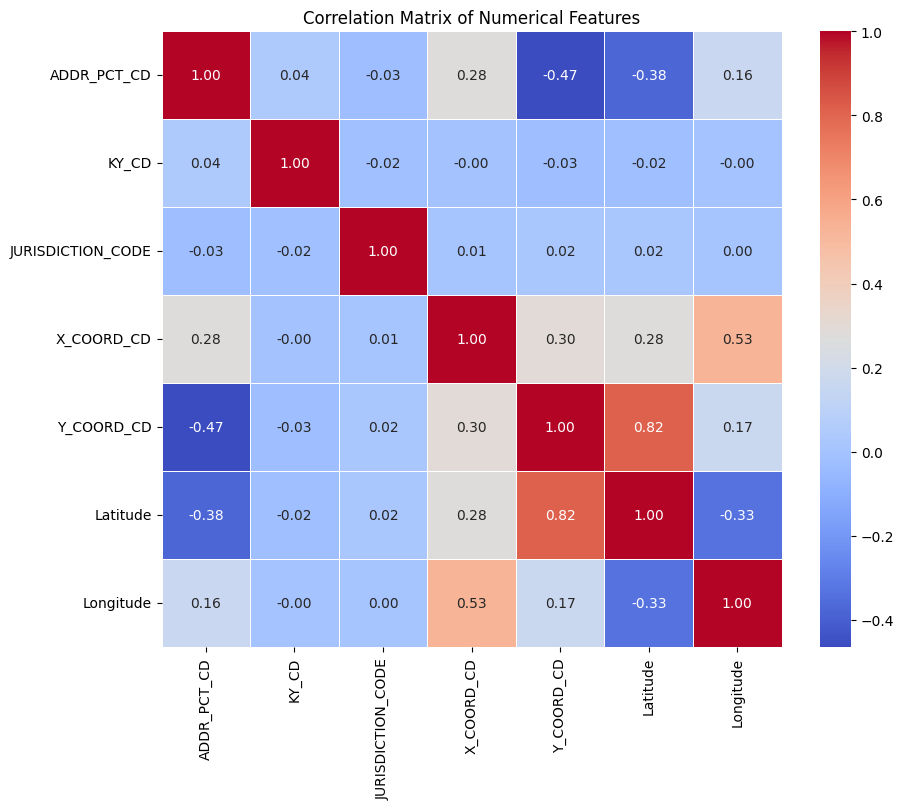

In [46]:
numerical_columns = ['ADDR_PCT_CD', 'KY_CD', 'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude']

numerical_data = data[numerical_columns]

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# PD_CD feature is dropped so not here

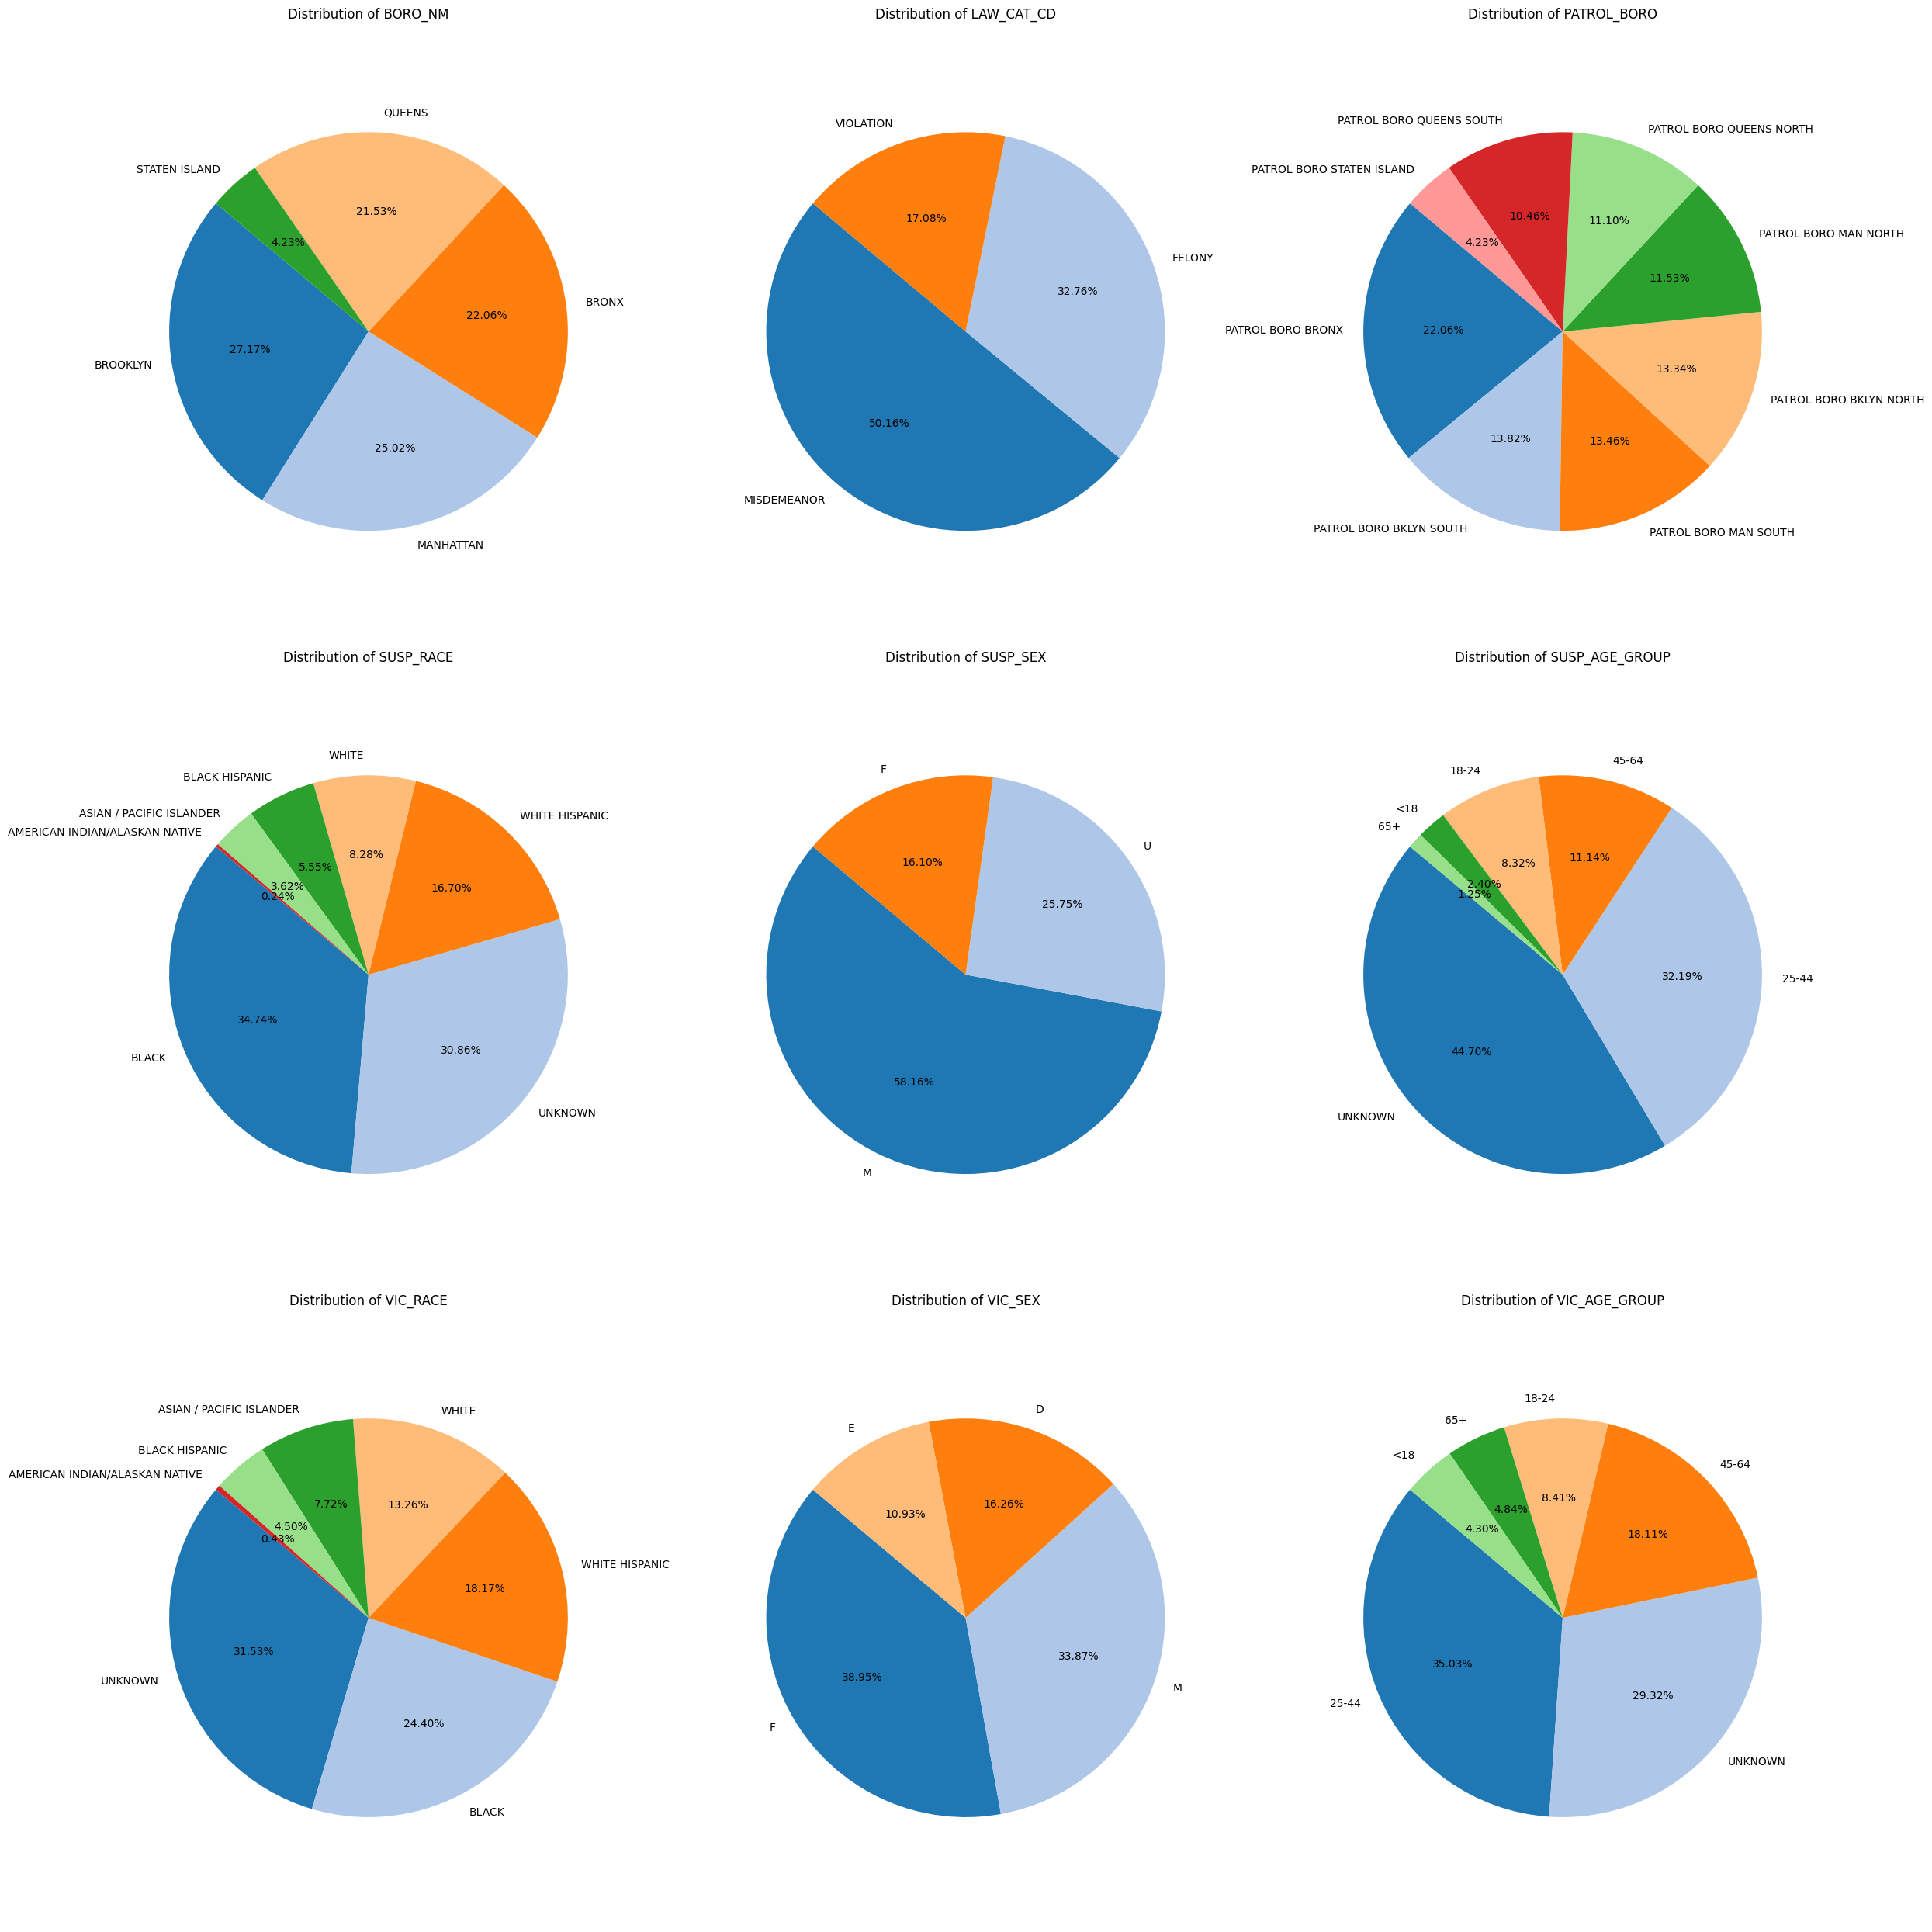

In [70]:
categorical_columns = ['BORO_NM', 'LAW_CAT_CD', 'PATROL_BORO', 'SUSP_RACE', 'SUSP_SEX', 'SUSP_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'VIC_AGE_GROUP']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25))

axes = axes.flatten()

for col, ax in zip(categorical_columns, axes):
    value_counts = data[col].value_counts()
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.2f%%', startangle=140, colors=plt.cm.tab20.colors)
    ax.set_title(f'Distribution of {col}')
    ax.axis('equal')
    # ax.legend(title=col, loc='upper right')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Comparing new categorical features with original features

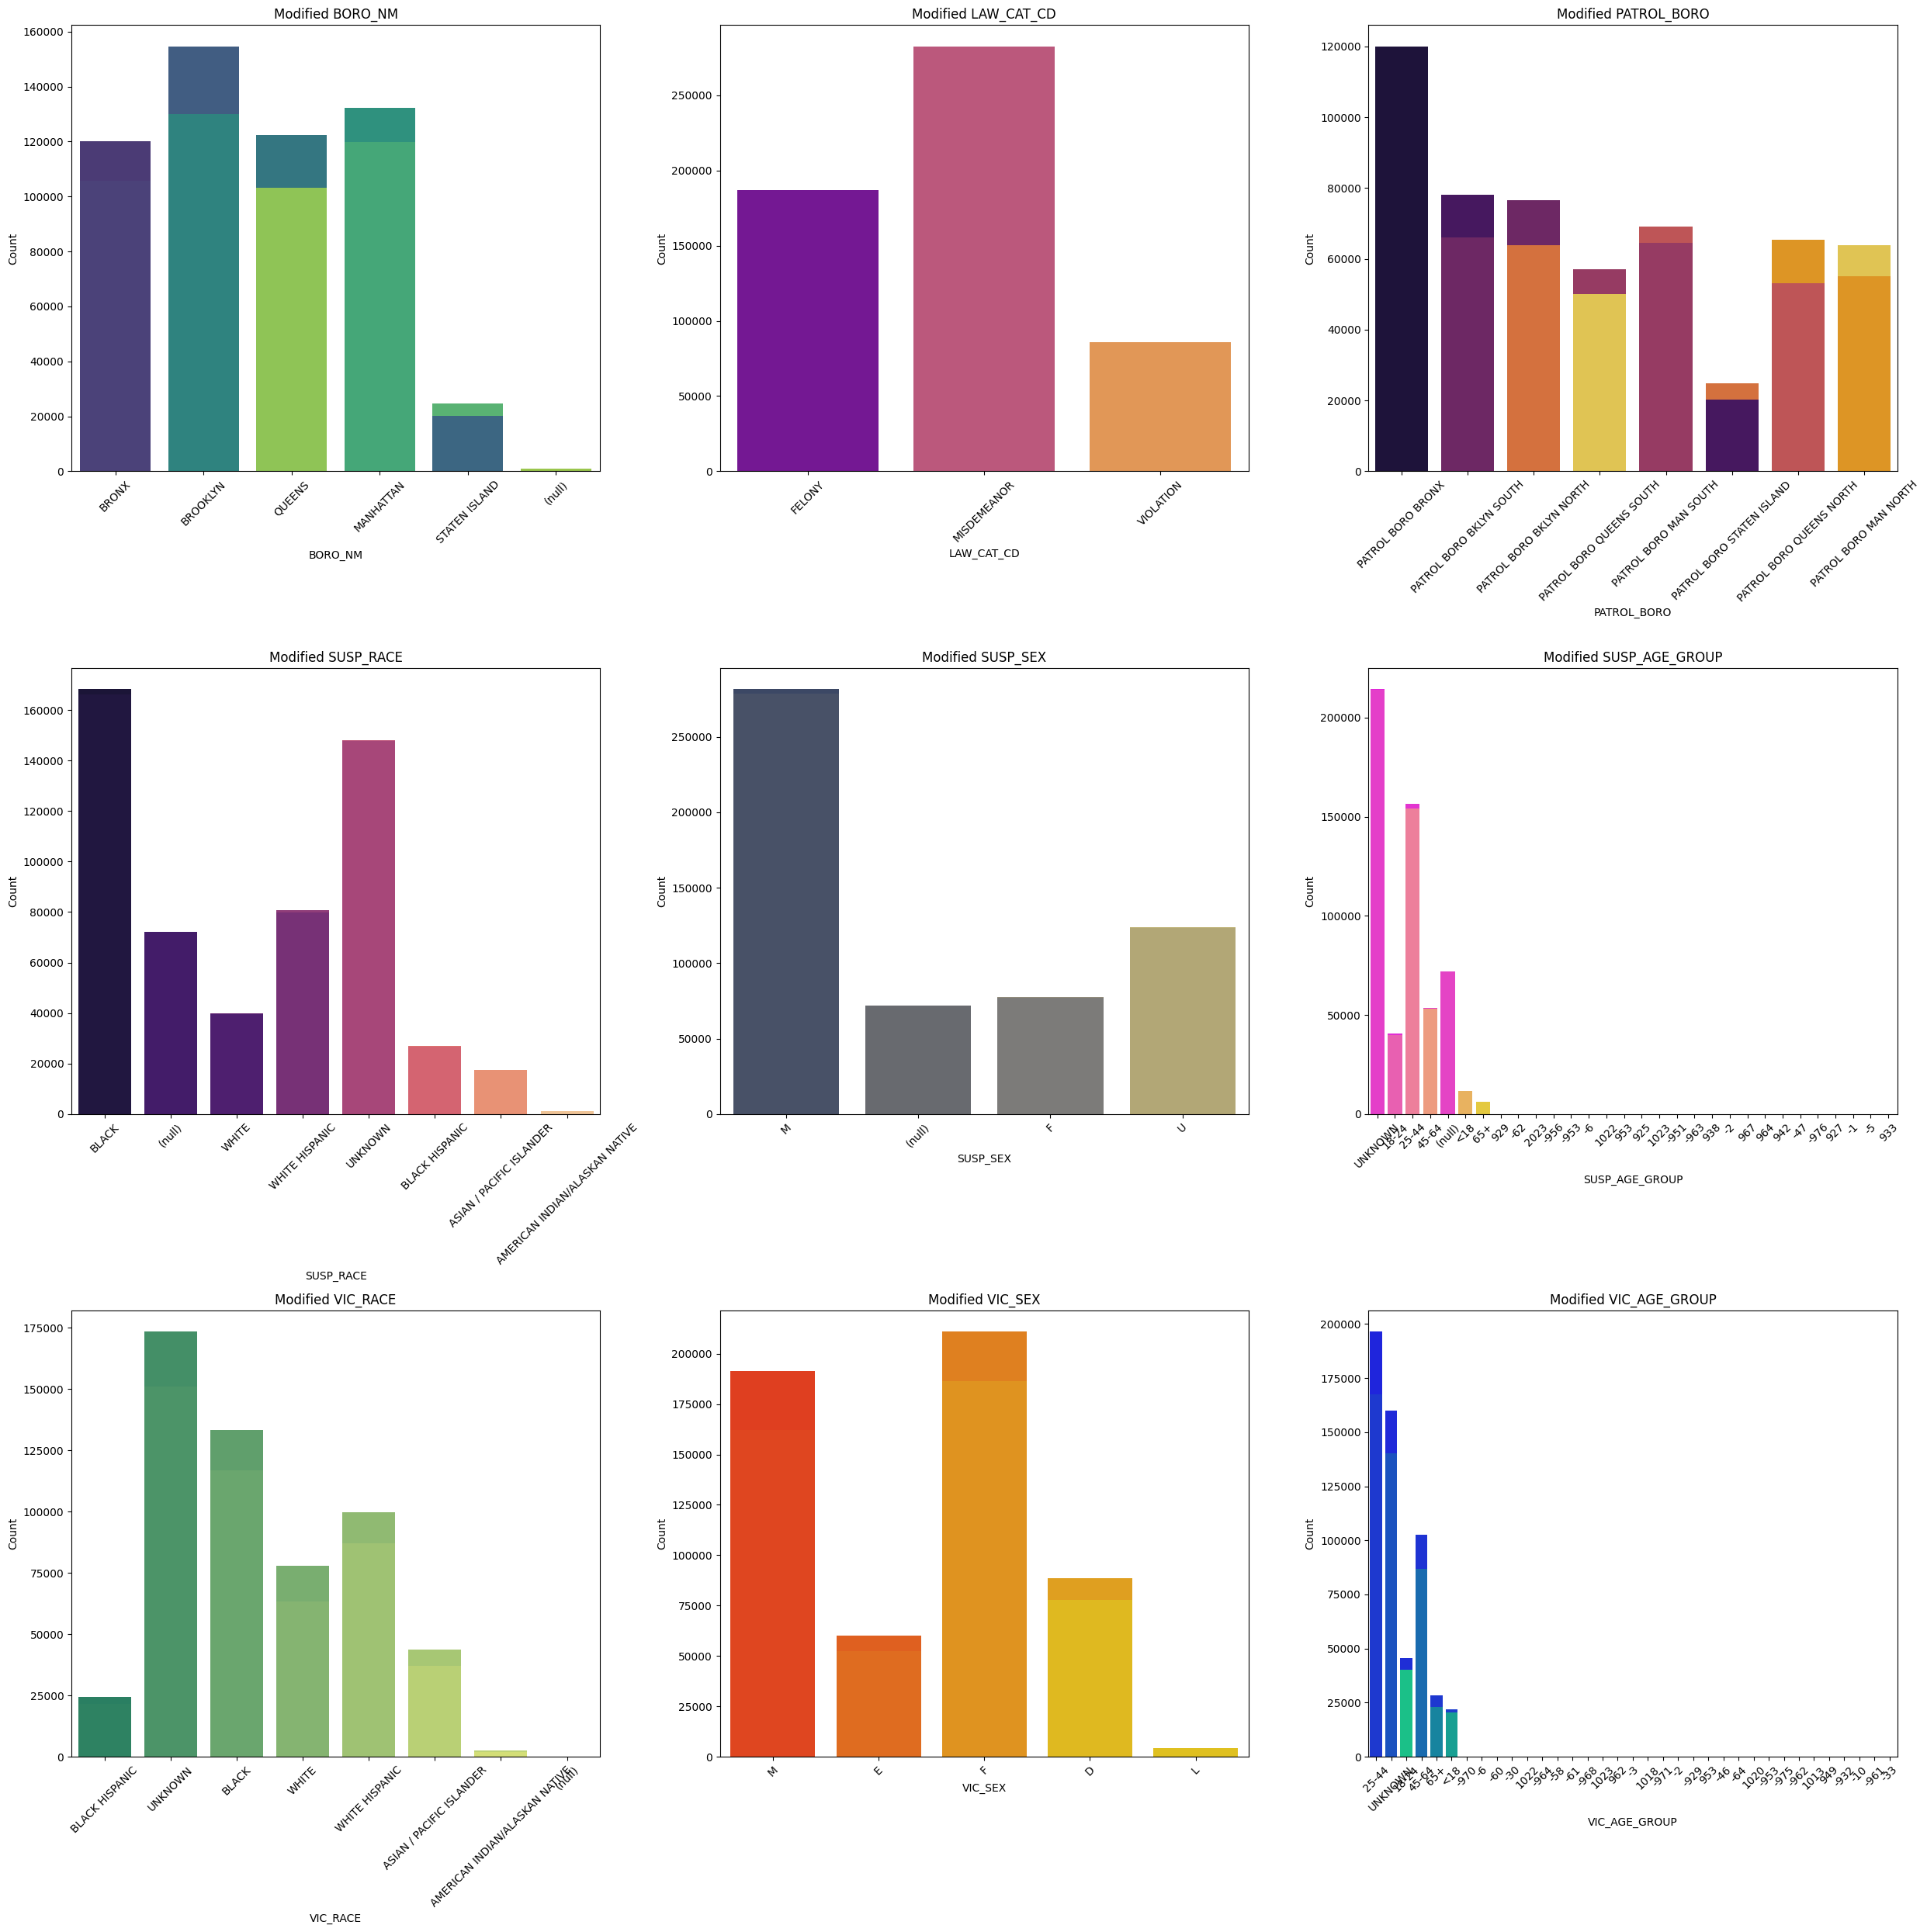

In [74]:
categorical_columns = ['BORO_NM', 'LAW_CAT_CD', 'PATROL_BORO', 'SUSP_RACE', 'SUSP_SEX', 'SUSP_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'VIC_AGE_GROUP']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25))

axes = axes.flatten()

color_maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'spring', 'summer', 'autumn', 'winter']

for i, col in enumerate(categorical_columns):
    sns.countplot(data=df, x=col, ax=axes[i], palette=color_maps[i])
    axes[i].set_title(f'Original {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

    sns.countplot(data=data, x=col, ax=axes[i], palette=color_maps[i])
    axes[i].set_title(f'Modified {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

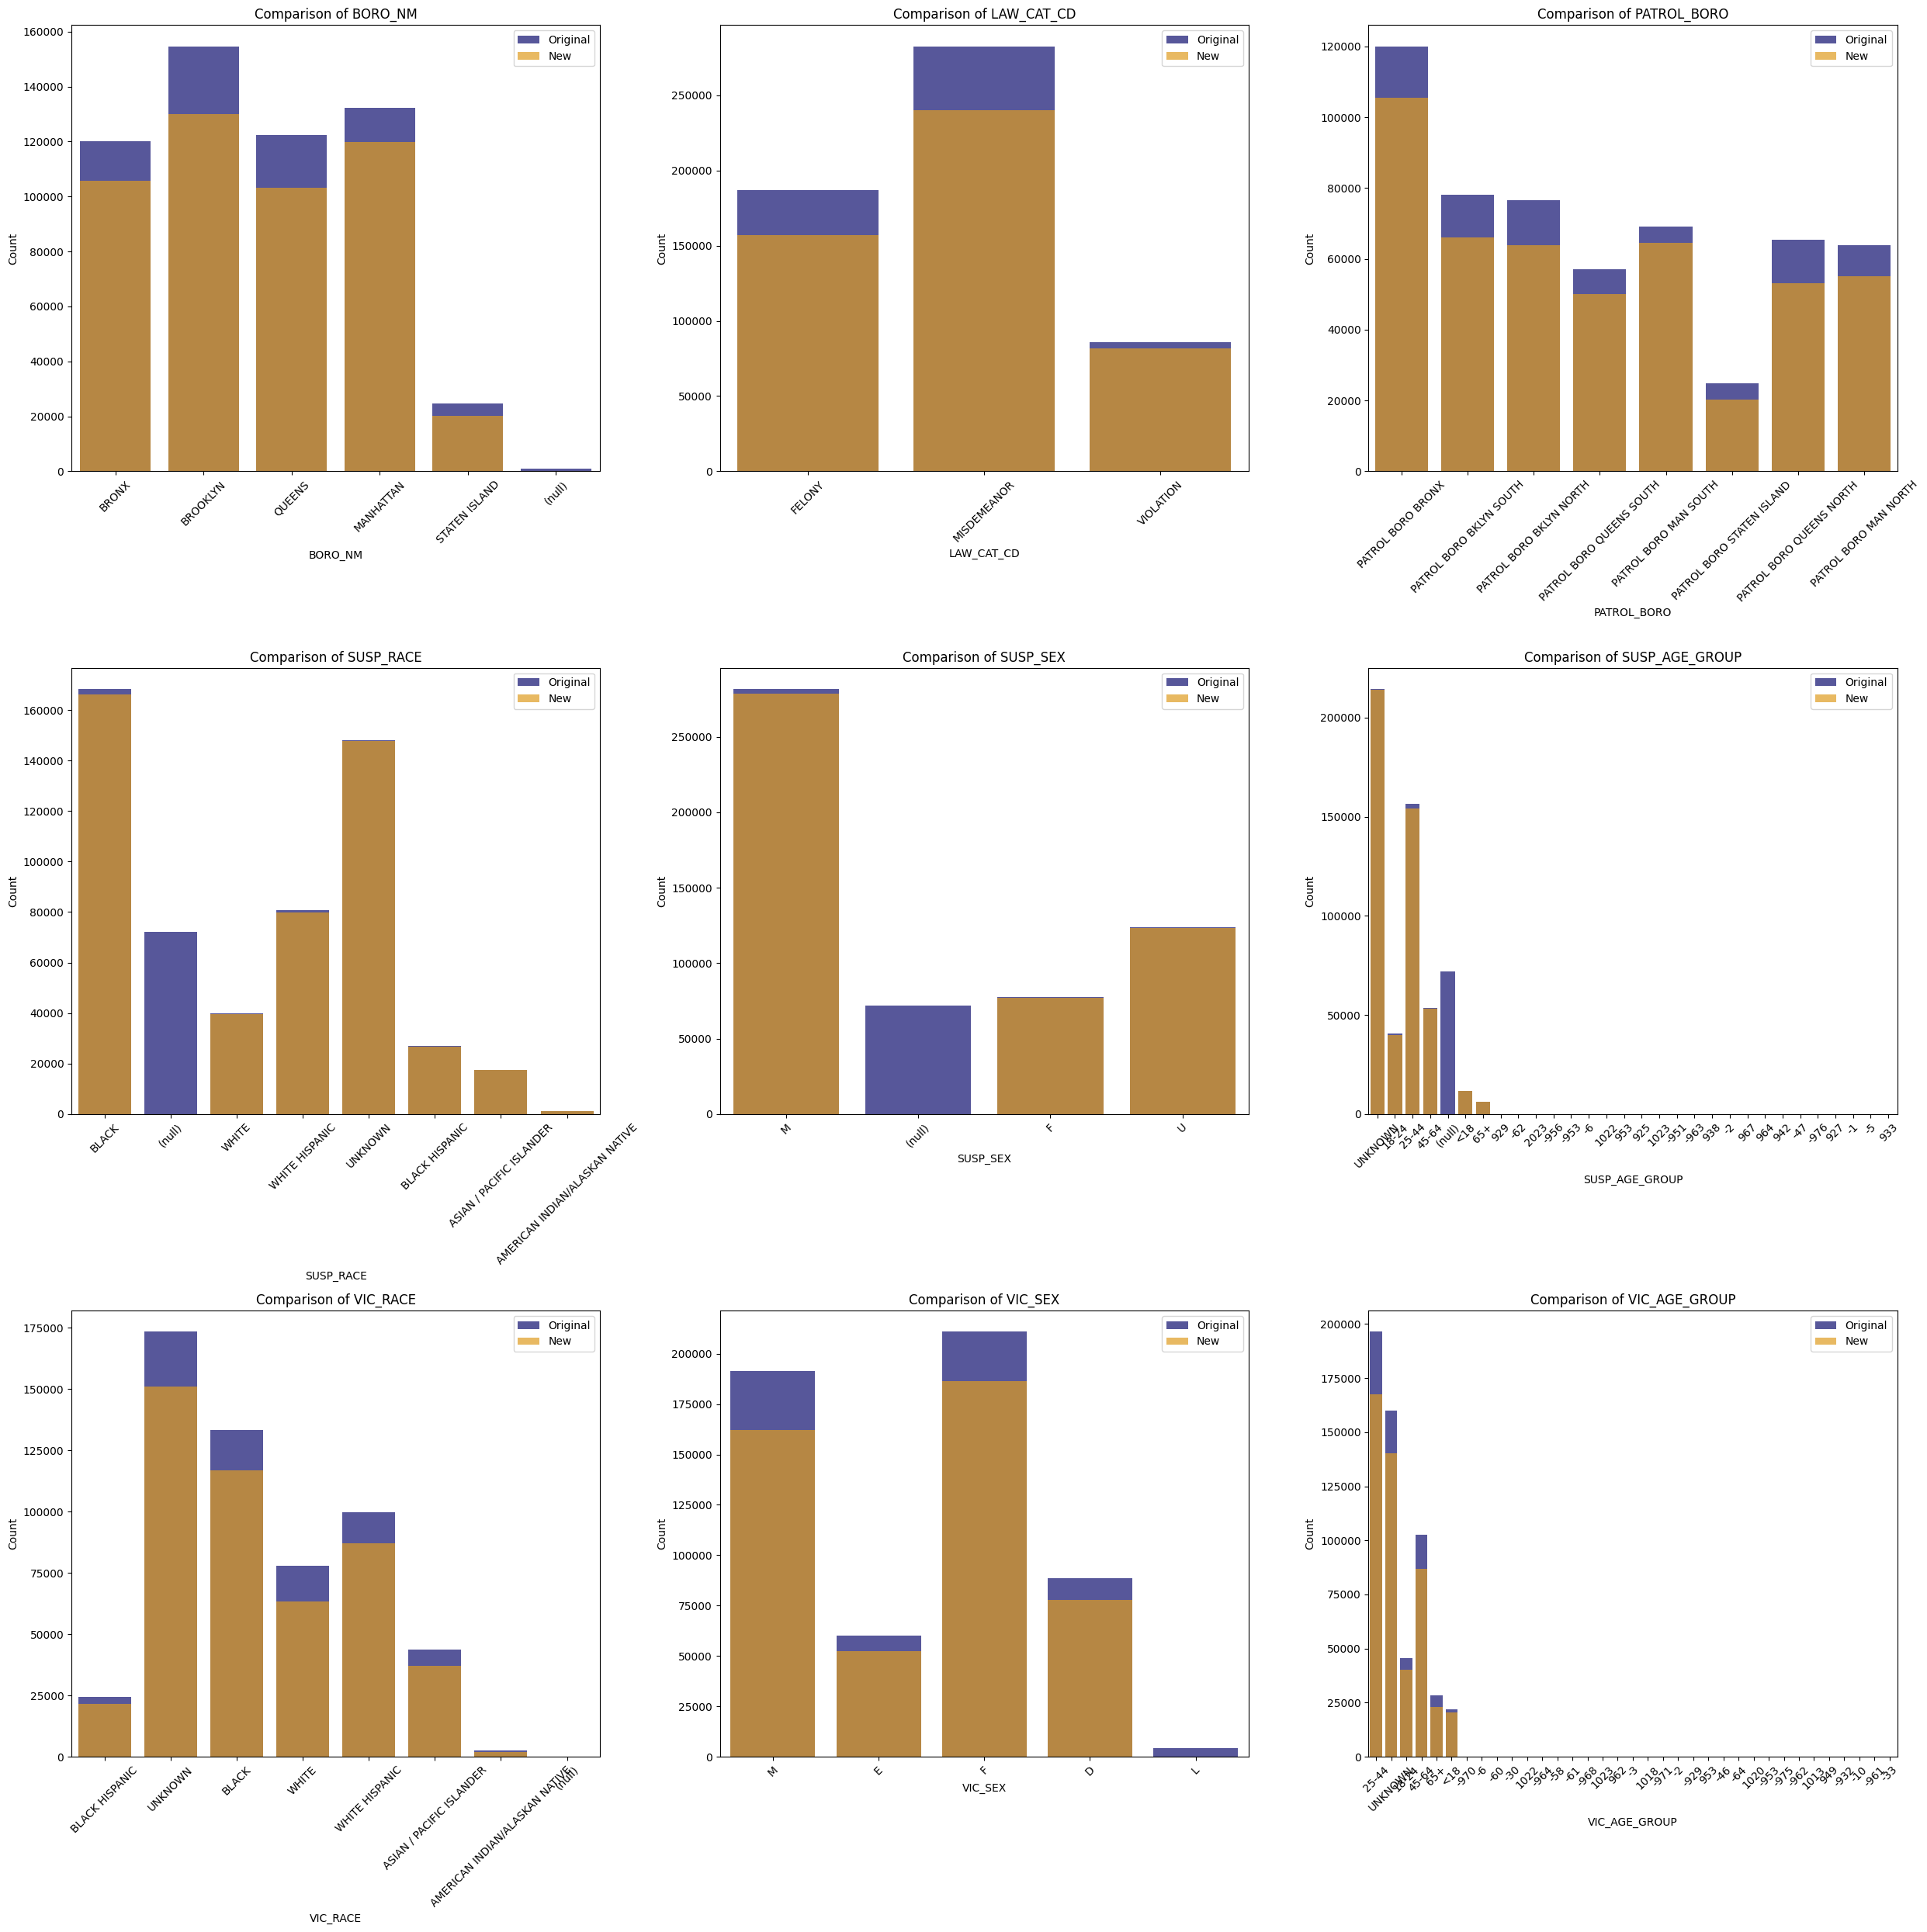

In [81]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25))

axes = axes.flatten()

original_color = 'navy'
new_color = 'orange'

for i, col in enumerate(categorical_columns):
    sns.countplot(data=df, x=col, ax=axes[i], color=original_color, label='Original', alpha=0.7)
    axes[i].set_title(f'Comparison of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

    sns.countplot(data=data, x=col, ax=axes[i], color=new_color, label='New', alpha=0.7)

    axes[i].legend()

plt.tight_layout()
plt.show()

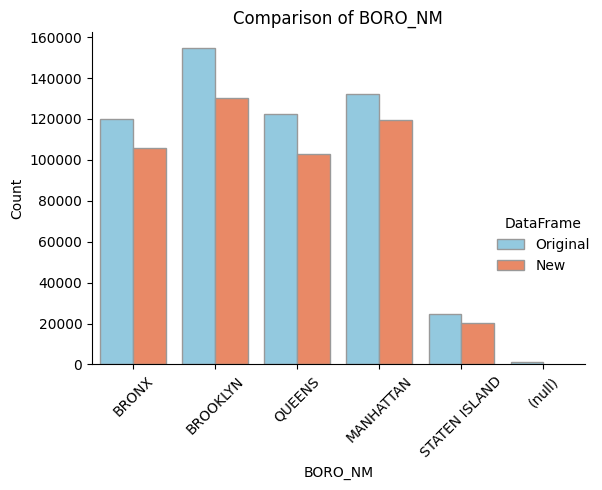

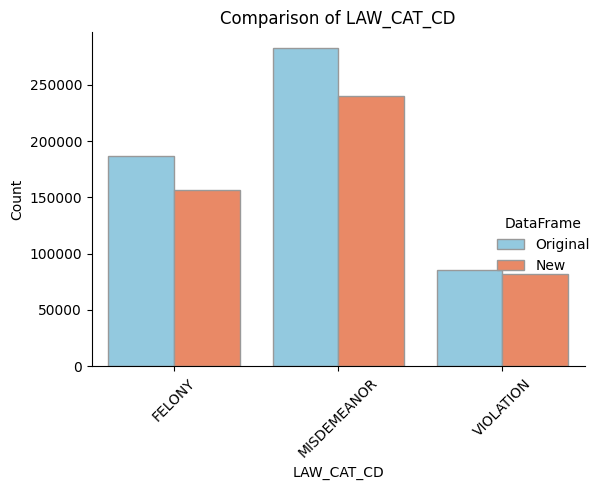

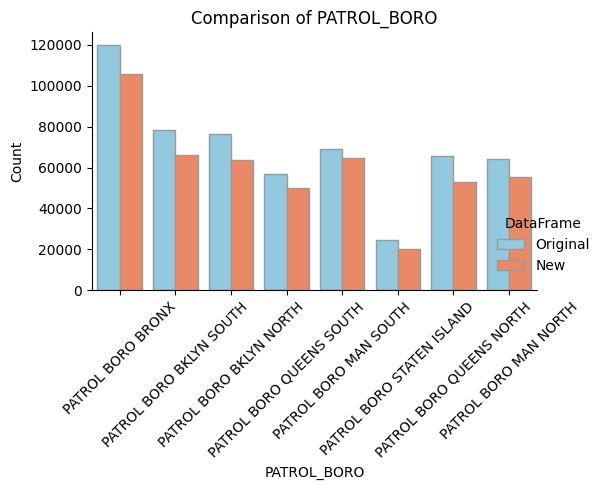

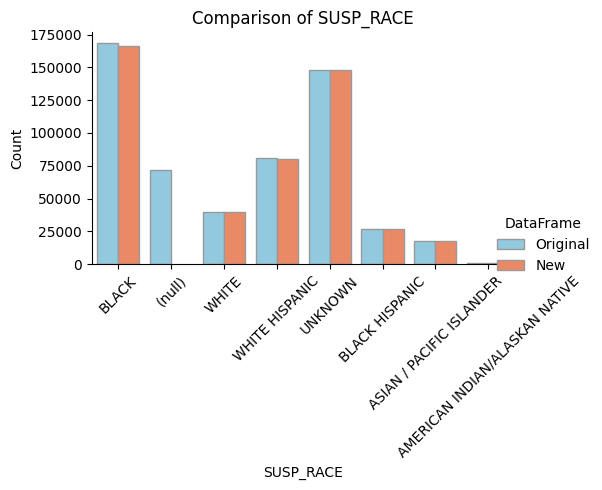

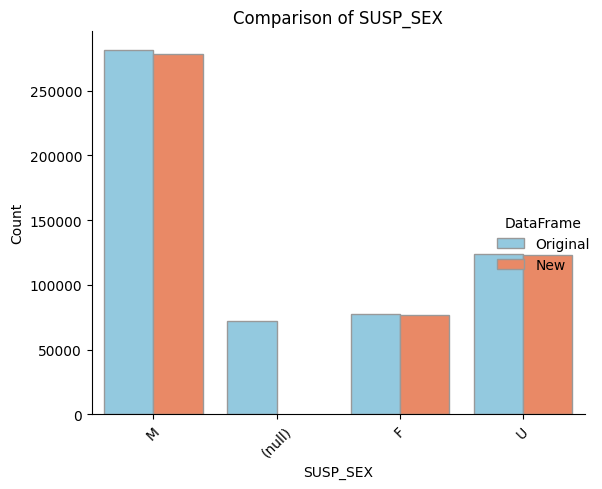

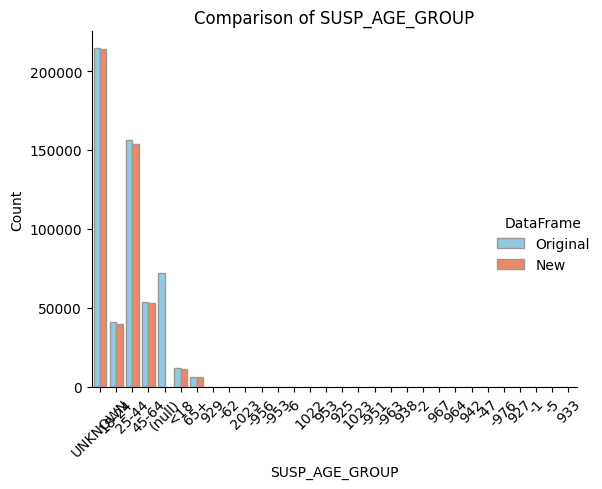

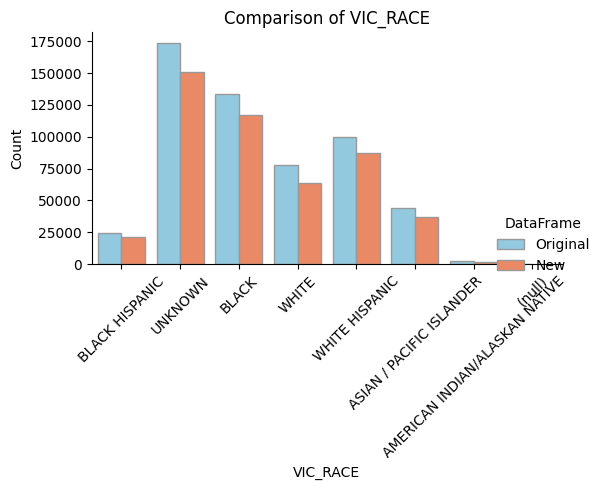

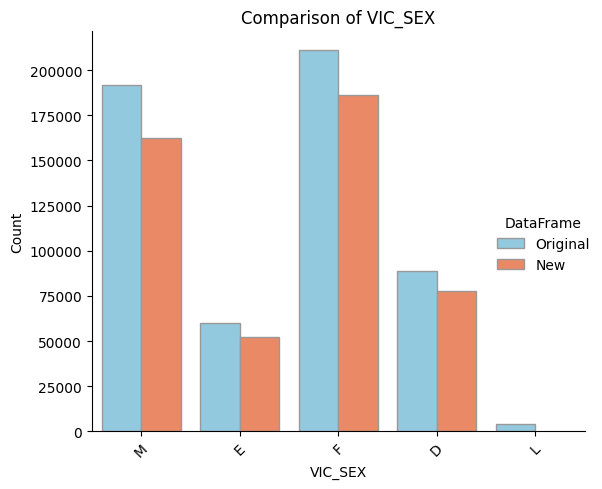

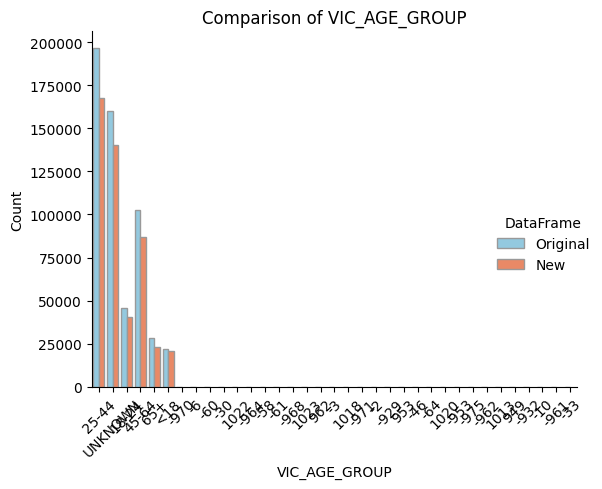

In [83]:
df['DataFrame'] = 'Original'
data['DataFrame'] = 'New'

combined_data = pd.concat([df, data])

for feature in categorical_columns:
    sns.catplot(
        data=combined_data, x=feature, hue="DataFrame", kind="count",
        palette={"Original": "skyblue", "New": "coral"},
        edgecolor=".6"
    )
    plt.title(f'Comparison of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

# Feature Encoding

1. One Hot ENcoding for:


  *`ADDR_PCT_CD`* ,
  *`BORO_NM`*,
  *`LAW_CAT_CD`*,
  *`PATROL_BORO`*,
  *`SUSP_RACE`*,
  *`SUSP_SEX`*,
  *`SUSP_AGE_GROUP`*,
  *`VIC_RACE`*,
  *`VIC_SEX`*,
  *`VIC_AGE_GROUP`*



In [47]:
# OHE the categorical columns
encoded_data = pd.get_dummies(data, columns=categorical_columns)

print(encoded_data.head())


   CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
0   269235387   06/03/2023     01:00:00          NaN       (null)   
1   262102261   01/18/2023     14:00:00          NaN       (null)   
2   267972239   05/07/2023     00:15:00          NaN       (null)   
9   278972931   12/14/2023     02:50:00   12/14/2023     02:52:00   
10  278470767   12/04/2023     15:53:00   12/04/2023     16:00:00   

   CRM_ATPT_CPTD_CD  JURISDICTION_CODE        JURIS_DESC  KY_CD  \
0         COMPLETED                  0  N.Y. POLICE DEPT    105   
1         COMPLETED                  0  N.Y. POLICE DEPT    113   
2         COMPLETED                  0  N.Y. POLICE DEPT    106   
9         COMPLETED                  0  N.Y. POLICE DEPT    235   
10        COMPLETED                  0  N.Y. POLICE DEPT    344   

   LOC_OF_OCCUR_DESC  ... VIC_SEX_D VIC_SEX_E VIC_SEX_F VIC_SEX_M  \
0             (null)  ...         0         0         0         1   
1             (null)  ...         0         